## BMI prediction

In [ ]:
!conda install -c conda-forge opencv
# !conda update ffmpeg

In [1]:
import cv2
import os
import time
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import backend as K
from keras.preprocessing import image

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
def load_base_model(input_shape=(224, 224, 3)):
    """
    load a pretrained ResNet152 model to extract features 
    @param input_shape: shape of input to the model
    """
    model = tf.keras.applications.ResNet152(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg"
    )
    model.trainable = False
    return model

In [3]:
def extract_features(x, datagen, model, batch_size, n_images):
    """
    extract features from images
    @param x: input images
    @param datagen: data generator
    @param model: resnet152
    @param batch_size
    @param n_images: number of images
    """
    print("Extracting features")
    features = np.zeros(shape=(n_images, 2048))
    
    generator = datagen.flow(x, batch_size=batch_size)
    
    total = 0
    left_index = 0
    
    for inputs_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        
        # track the number of processed images and 
        gap = features_batch.shape[0]
        total += gap
        gap_diff = total - n_images
        gap_diff = gap_diff if gap_diff > 0 else 0
        
        features[left_index : left_index + (gap-gap_diff)] = features_batch[0:gap-gap_diff]
        left_index += gap
        
        if total >= n_images:
            break
            
    return features

In [4]:
def read_and_preprocess_img(image_path, process_image_path, image_ids, 
                            input_shape=(224,224,3)):
    """
    size of processed image: (512, 512, 3)
    @param image_path: base path of raw input image
    @param process_image_path: base path of human parsing output images
    @param image_ids: a list of image ids that contain human body
    @param input_shape: default input shape of resenet model to resize images
    """
    print("Reading raw input and processed images")
    input_images = []
    
    for image_id in image_ids:
        # load raw input image
        raw_input_image = cv2.imread("%s/%d.jpg" % (image_path, image_id))
        raw_input_image = cv2.cvtColor(raw_input_image, cv2.COLOR_BGR2RGB)
        raw_input_image = cv2.resize(raw_input_image, (input_shape[0], input_shape[1]))

        # load processed image after human parsing
        preprocessed_input_image = image.load_img(
            "%s/%d.png"% (process_image_path, image_id), 
            target_size=input_shape
        )
        preprocessed_input_image = image.img_to_array(preprocessed_input_image)

        # convert to silhouette images
        for channel in range(3):
            preprocessed_input_image[preprocessed_input_image[:,:,channel] > 0] = 1

        input_images.append(raw_input_image * preprocessed_input_image)
    
    return np.array(input_images)

In [5]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [6]:
# load image_ids that are detected to contain human body
human_detect_res = pd.read_csv("../human_detection/result/frcnn_result.csv")
image_ids = human_detect_res[human_detect_res["pred_label"] == 1]["image_id"]

image_base_path = "../HKTVMall_data"
process_image_path = "process_images"

batch_size = 32
input_shape = (224, 224, 3)

In [39]:
start = time.time()

# load and preprocess images
input_images = read_and_preprocess_img(image_base_path, process_image_path, image_ids, input_shape)

# extract features using ResNet152 base_model
datagen = image.ImageDataGenerator(samplewise_center=True)
base_model = load_base_model(input_shape)
features = extract_features(input_images, datagen, base_model, batch_size, len(image_ids))

# predict bmi using pretrained model
print("Predicting BMI")
model = keras.models.load_model('model/4.053_model.h5', 
                                custom_objects= {'coeff_determination': coeff_determination}
                               )

preds = model.predict(features)
bmi_df = human_detect_res[human_detect_res["pred_label"] == 1].reset_index(drop=True).copy()
bmi_df["pred_bmi"] = preds

if not os.path.exists("result"):
    os.makedirs("result")

bmi_df.to_csv("result/bmi_pred.csv", index=False)

end = time.time()
print("Total time used: %.2f" % (end-start))


Read raw input and processed images
Extracting features
Predicting BMI
Total time used: 36.88


In [23]:
def plot_image(image_path, process_path, image_id, bmi, show_process_image=False):
    raw_input_image = cv2.imread("%s/%d.jpg" % (image_path, image_id))
    raw_input_image = cv2.cvtColor(raw_input_image, cv2.COLOR_BGR2RGB)

    f, ax = plt.subplots(1,2)
    ax[0].imshow(raw_input_image)

    if show_process_image:
        preprocessed_input_image = image.load_img("%s/%d.png"% (process_image_path, image_id))
        ax[1].imshow(preprocessed_input_image)

    plt.title("Image %d, Predicted BMI: %.2f" % (image_id, bmi[bmi["image_id"] == image_id]["pred_bmi"]))

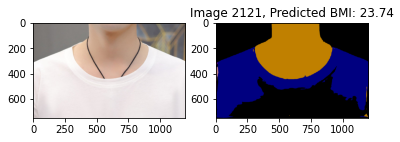

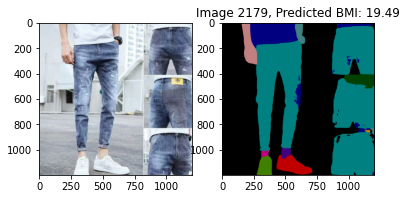

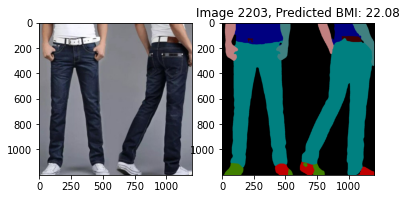

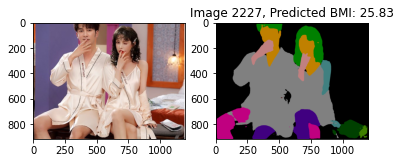

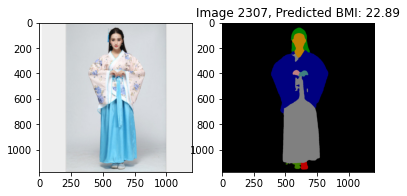

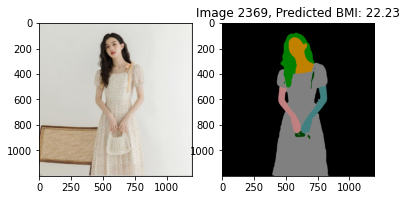

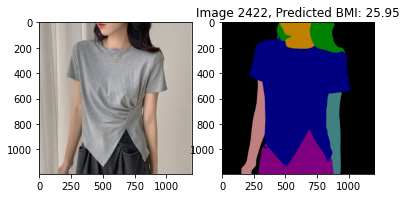

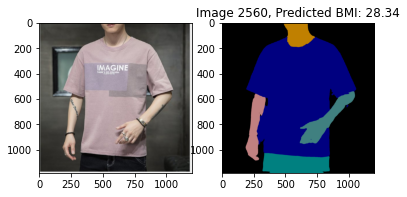

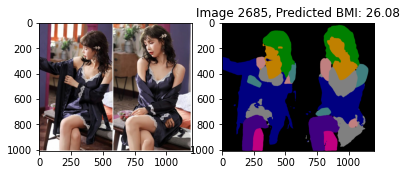

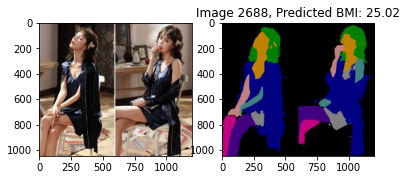

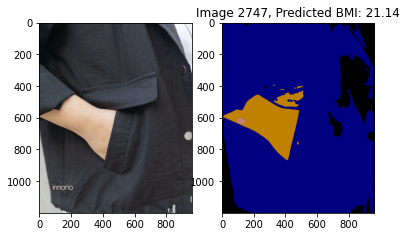

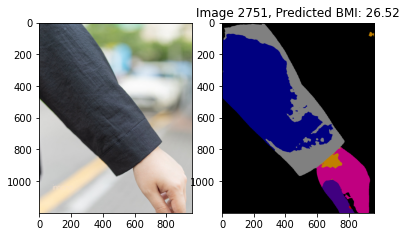

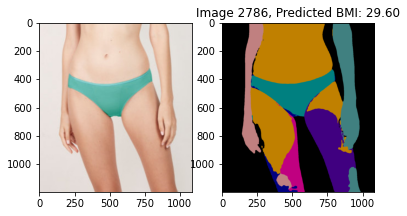

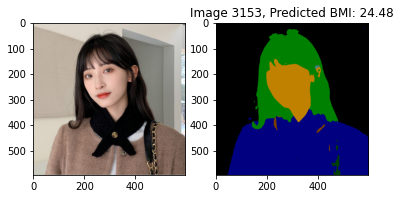

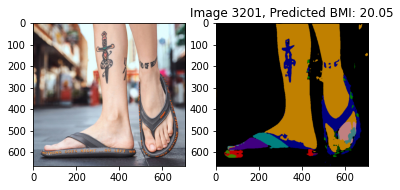

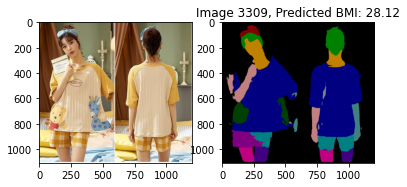

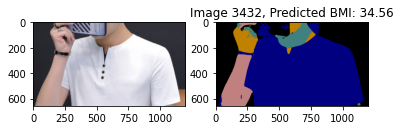

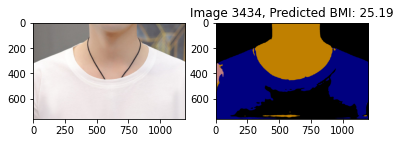

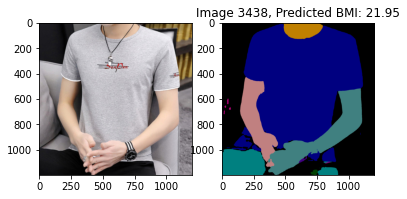

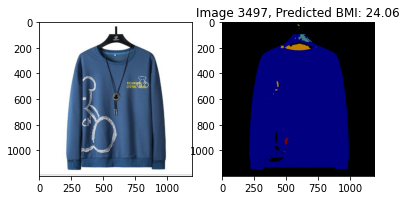

In [31]:
# bmi_df = pd.read_csv("result/bmi_pred.csv")

for image_id in image_ids[80:100]:
    plot_image(image_base_path, process_image_path, image_id, bmi_df, show_process_image=True)